In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
from tensorflow import keras
from keras import layers

In [3]:
from tensorflow.keras.applications import VGG19

In [4]:
import glob

In [5]:
image_paths = sorted(glob.glob('images/test2017/*.jpg'))

In [7]:
len(image_paths)
    

13111

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
def degrade_image(original):
    
    target = original.copy()
    degraded = original.copy()


    if np.random.rand() < 0.95:
      k = np.random.choice([3, 5, 7, 9, 15])
      sigma = np.random.uniform(0.5, 5.0)
      degraded = cv2.GaussianBlur(degraded, (k, k), sigmaX=sigma)

    '''
    if np.random.rand() < 0.4:
      size = np.random.randint(5, 25)
      kernel_motion = np.zeros((size, size))
      kernel_motion[size // 2, :] = np.ones(size)
      angle = np.random.randint(0, 360)
      M = cv2.getRotationMatrix2D((size / 2, size / 2), angle, 1)
      kernel_motion = cv2.warpAffine(kernel_motion, M, (size, size))
      kernel_motion /= np.sum(kernel_motion)
      degraded = cv2.filter2D(degraded, -1, kernel_motion)
      '''

    
    if np.random.rand() < 0.9:
      k1 = np.random.choice([3, 5, 7])
      sigma1 = np.random.uniform(0.5, 1.0)
      k2 = np.random.choice([9, 15,17])
      sigma2 = np.random.uniform(1.0, 5.0)
      mask = np.random.rand(*degraded.shape[:2])
      blur_light = cv2.GaussianBlur(degraded, (k1,k1), sigma1)
      blur_heavy = cv2.GaussianBlur(degraded, (k2,k2), sigma2)
      degraded = np.where(mask[..., None] > 0.5, blur_light, blur_heavy)

      

    return degraded, target

In [9]:
def degrade_image_v1(original):
    target = original.copy()
    degraded = original.copy()
    if np.random.rand() < 0.1:
        return degraded, target
    k = np.random.choice([3, 5, 7, 9, 11,13])
    sigma = np.random.uniform(0.5, 5.0)
    degraded = cv2.GaussianBlur(degraded, (k, k), sigmaX=sigma)
    return degraded, target
    

In [8]:
def _load_img(path):
    path = path.numpy().decode('utf-8')
    img = cv2.imread(path)
    img = cv2.resize(img, (584, 480))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
    blurred,img = degrade_image(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    blurred = tf.convert_to_tensor(blurred, dtype=tf.float32)
    return blurred,img

In [9]:
def load_img(path):
  blurred,img =  tf.py_function(func=_load_img, inp=[path], Tout=(tf.float32, tf.float32))
  blurred.set_shape([480, 584,3])
  img.set_shape([480, 584,3])
  return blurred,img

In [16]:
a, b = load_img(image_paths[31])

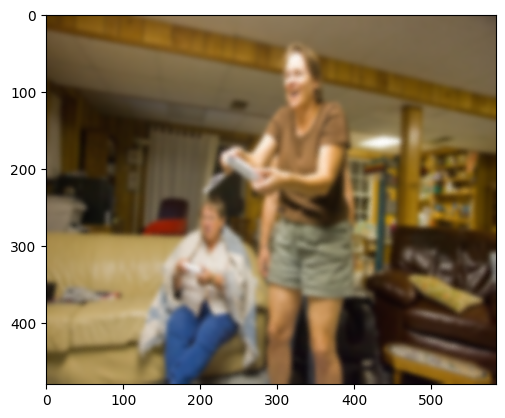

In [17]:
plt.imshow(a)

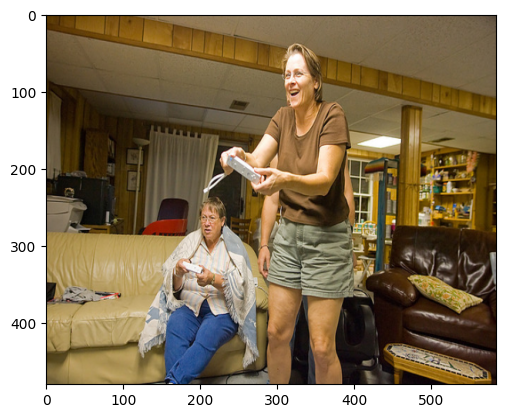

In [45]:
plt.imshow(b)

In [18]:
ds = tf.data.Dataset.from_tensor_slices(image_paths)
ds = ds.shuffle(buffer_size=len(image_paths))
ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(16)
ds = ds.repeat()
ds = ds.prefetch(tf.data.AUTOTUNE)

In [41]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet(input_shape=(480, 584, 3)):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D(2)(c3)

    b = conv_block(p3, 256)

    u3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = conv_block(u3, 128)

    u2 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = conv_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = conv_block(u1, 32)

    out = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(u1)

    model = keras.models.Model(inputs, out, name="unet_sharpen")
    return model


In [10]:
def residual_block(x, filters):
    shortcut = x
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)  
    return x

def build_resunet(input_shape=(480, 584, 3)):
    inputs = layers.Input(shape=input_shape)

    c1 = residual_block(inputs, 32)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = residual_block(p1, 64)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = residual_block(p2, 128)
    p3 = layers.MaxPooling2D(2)(c3)

    b = residual_block(p3, 256)

    u3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = residual_block(u3, 128)

    u2 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = residual_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = residual_block(u1, 32)

    out_residual = layers.Conv2D(3, 3, padding="same")(u1)
    out = layers.Add()([inputs, out_residual])   # degraded + predicted residual
    out = layers.Activation("sigmoid")(out)        

    model = keras.models.Model(inputs, out, name="resunet_sharpen")
    return model


In [74]:
from tensorflow.keras.applications.vgg19 import preprocess_input

In [62]:
#Transfer learning
def build_vgg19(input_shape=(480, 584, 3)):
    input_img = layers.Input(shape=input_shape)
    
    #preprocess = layers.Lambda(preprocess_input)(input_img)

    vgg= VGG19(weights=None, include_top=False, input_tensor=input_img)
    for layer in vgg.layers:
        layer.trainable = True

    encoder_output = vgg.get_layer("block3_conv3").output


    x = layers.UpSampling2D((2, 2))(encoder_output)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    model = keras.models.Model(inputs=input_img, outputs=decoded)
    return model

In [63]:
model = build_vgg19()

In [126]:
model = keras.models.load_model(
    "model_v1.keras",
    custom_objects={"ssim_loss": ssim_loss}
)

In [71]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [159]:
def ssim_mae_loss(y_true, y_pred):
    return  tf.keras.losses.MAE(y_true, y_pred) + 0.1*ssim_loss(y_true, y_pred)

In [64]:
model.compile(
    optimizer="nadam",
    loss="mae"
)

In [60]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 480, 584, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 584, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 584, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 292, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 292, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 292, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 120, 146, 128)     0   

In [152]:
model.fit(ds,epochs=30, steps_per_epoch=30)

Epoch 1/30
30/30 [==============================] - 15s 477ms/step - loss: 0.0453
Epoch 2/30
30/30 [==============================] - 15s 491ms/step - loss: 0.0446
Epoch 3/30
30/30 [==============================] - 15s 486ms/step - loss: 0.0467
Epoch 4/30
30/30 [==============================] - 14s 476ms/step - loss: 0.0473
Epoch 5/30
30/30 [==============================] - 14s 468ms/step - loss: 0.0433
Epoch 6/30
30/30 [==============================] - 15s 490ms/step - loss: 0.0442
Epoch 7/30
30/30 [==============================] - 15s 488ms/step - loss: 0.0444
Epoch 8/30
30/30 [==============================] - 14s 479ms/step - loss: 0.0474
Epoch 9/30
30/30 [==============================] - 14s 468ms/step - loss: 0.0434
Epoch 10/30
30/30 [==============================] - 14s 476ms/step - loss: 0.0418
Epoch 11/30
30/30 [==============================] - 14s 480ms/step - loss: 0.0462
Epoch 12/30
30/30 [==============================] - 14s 481ms/step - loss: 0.0485
Epoch 13/30
3

In [35]:
tf.keras.backend.clear_session()

In [212]:
batch = next(iter(ds))

In [213]:
predicted_batch = model.predict(batch[0])

1/1 [==============================] - 0s 94ms/step


In [128]:
again = model.predict(predicted_batch)

1/1 [==============================] - 0s 93ms/step


In [223]:
i = 3
input = batch[0][i]
output = batch[1][i]
predicted = predicted_batch[i]
#predicted2 = predicted_batch2[i]
#predicted2 = again[i]

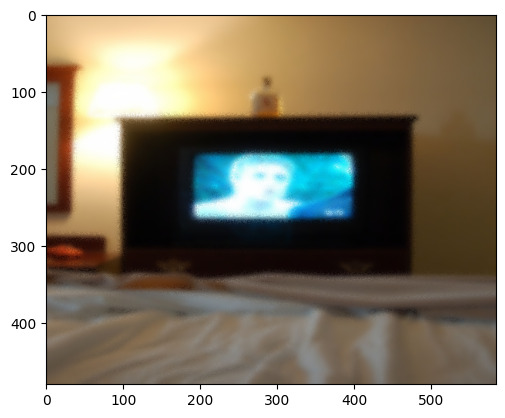

In [224]:
plt.imshow(input)

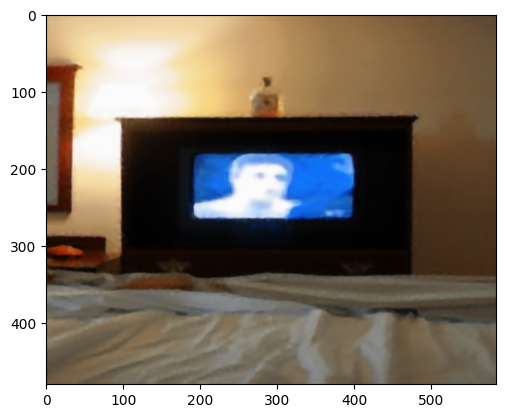

In [225]:
plt.imshow(predicted)

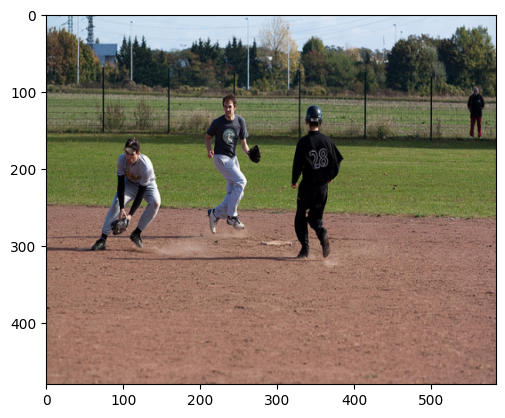

In [175]:
plt.imshow(output)

In [151]:
model.save("model_final3.keras")